<a href="https://colab.research.google.com/github/norulwahab/nor_python_ml/blob/main/Malaria_cnn_Custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten, InputLayer,BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [18]:
dataset, dataset_info=tfds.load('malaria',with_info=True, as_supervised=True,shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteERZLEO/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [19]:
def splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset,val_dataset,test_dataset

In [20]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)


##Data Visualization##

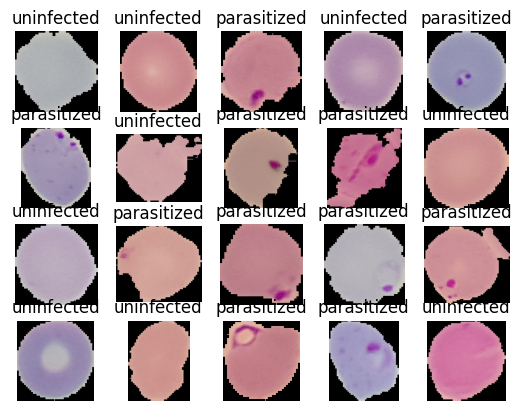

In [21]:
for i, (image, label) in enumerate(train_dataset.take(20)):
  plt.subplot(4,5,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

##Processing##


In [22]:
IMAGE_SIZE=224
def resize_rescale(image,label):
  return tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255.0,label

In [23]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
# for image,label in train_dataset.take(1):
#   print(image,label)

In [24]:
train_dataset=train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
val_dataset=val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
test_dataset=test_dataset.batch(1)

##Model Creation and Training


In [27]:
class Custom_Dense(Layer):
  def __init__(self, output_units,activation):
    super(Custom_Dense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = 'random_normal', trainable =True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = 'random_normal', trainable = True)

  def call(self,input_features):
    pre_output = tf.matmul(input_features,self.w) + self.b
    if (self.activation == 'relu'):
      return tf.nn.relu(pre_output)
    elif (self.activation == 'sigmoid'):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [28]:
lenet_custom_model = tf.keras.models.Sequential([
                                      InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),

                                      Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                                      BatchNormalization(),
                                      MaxPooling2D(pool_size=2, strides=2),

                                      Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                                      BatchNormalization(),
                                      MaxPooling2D(pool_size=2, strides=2),

                                      Flatten(),
                                      Custom_Dense(100, activation='relu'),
                                      BatchNormalization(),
                                      Custom_Dense(10, activation='relu'),
                                      BatchNormalization(),

                                      Custom_Dense(1, activation='sigmoid')
                                      ])
lenet_custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [29]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(),metrics='accuracy')

In [30]:
history= lenet_custom_model.fit(train_dataset,validation_data= val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 101s 121ms/step - loss: 0.3174 - accuracy: 0.8717 - val_loss: 0.4127 - val_accuracy: 0.8526
Epoch 2/20
689/689 [==============================] - 78s 113ms/step - loss: 0.1869 - accuracy: 0.9359 - val_loss: 0.1615 - val_accuracy: 0.9514
Epoch 3/20
689/689 [==============================] - 58s 84ms/step - loss: 0.1506 - accuracy: 0.9477 - val_loss: 0.1765 - val_accuracy: 0.9441
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1152 - accuracy: 0.9587 - val_loss: 0.1822 - val_accuracy: 0.9426
Epoch 5/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1065 - accuracy: 0.9609 - val_loss: 0.1945 - val_accuracy: 0.9339
Epoch 6/20
689/689 [==============================] - 57s 82ms/step - loss: 0.0714 - accuracy: 0.9746 - val_loss: 0.2532 - val_accuracy: 0.8962
Epoch 7/20
689/689 [==============================] - 44s 63ms/step - loss: 0.0577 - accuracy: 0.9786 - val_loss: 0.2056 - val_accura

<ipython-input-31-2e8b6b8ce6d7>:6: UserWarning: The label '_' of 'o' starts with '_'. It is thus excluded from the legend.
  plt.legend('Training_Loss','Validation_Loss')
<ipython-input-31-2e8b6b8ce6d7>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training_Loss','Validation_Loss')


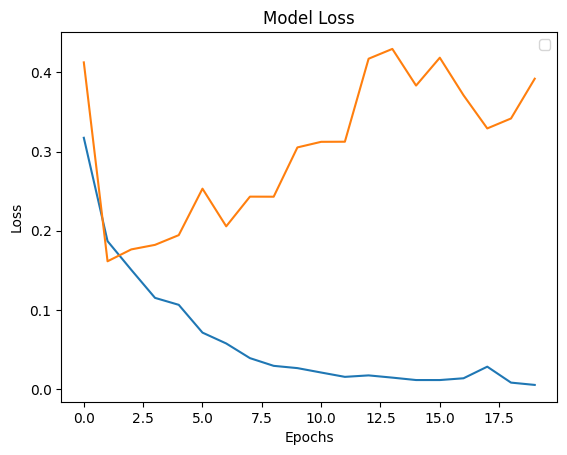

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend('Training_Loss','Validation_Loss')
plt.show()

<ipython-input-32-857611124634>:6: UserWarning: The label '_' of 'c' starts with '_'. It is thus excluded from the legend.
  plt.legend('Training_Accuracy','Validation_Accuracy')
<ipython-input-32-857611124634>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training_Accuracy','Validation_Accuracy')


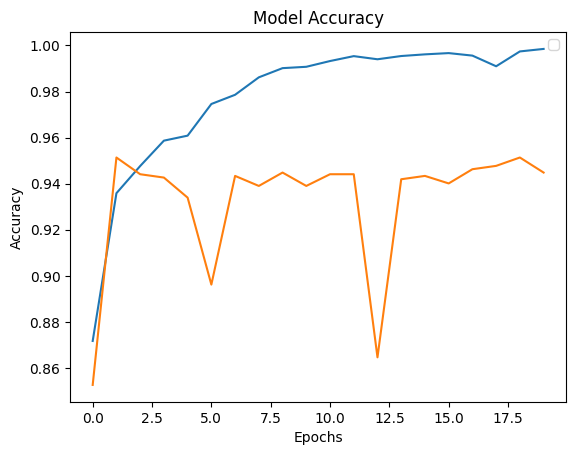

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend('Training_Accuracy','Validation_Accuracy')
plt.show()

In [33]:
lenet_custom_model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.4153 - accuracy: 0.9394


[0.4152872860431671, 0.9394268989562988]

In [34]:
lenet_custom_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 10s 10s/step


0.99999976

In [35]:
def infected_or_not(x):
  if(x<0.5):
    return str('I')
  else:
    return str('U')

1/1 [==============================] - 0s 18ms/step


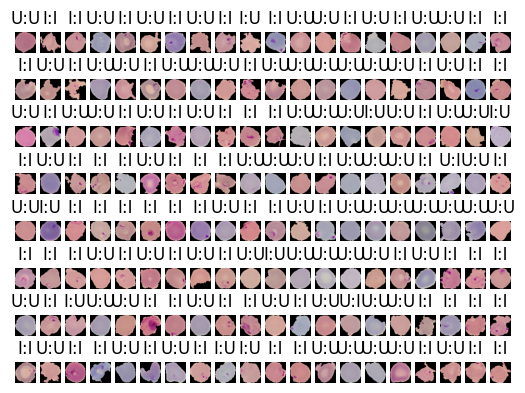

In [36]:
for i,(image,label) in enumerate(test_dataset.take(160)):
  plt.subplot(8,20,i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0])) + ':' +str(infected_or_not(lenet_custom_model.predict(image)[0][0])))
  plt.axis('off')